###Unsupervised Learning (Clustering)

In [ ]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler


In [ ]:
df = pd.read_csv("heart_disease_reduced.csv")
print("Shape:", df.shape)
df.head()
# Cell 3: Split into features and target
X = df.drop(columns=["target"])
y = df["target"]
print("Feature matrix shape:", X.shape)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



Shape: (303, 9)
Feature matrix shape: (303, 8)


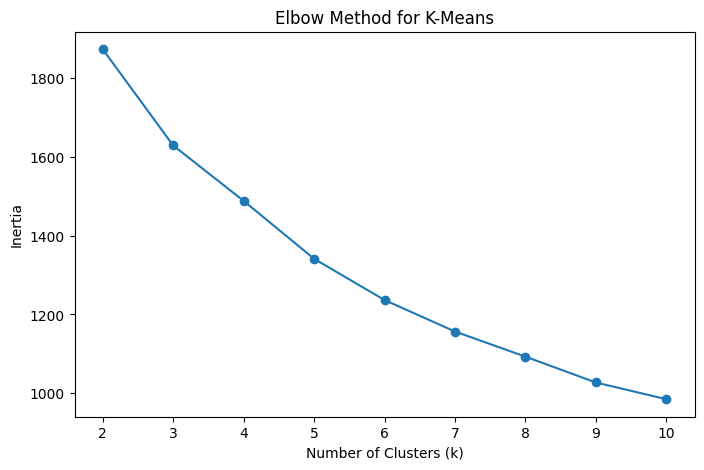

In [ ]:
# Cell 3: K-Means - Elbow method
inertia = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, "o-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means")
plt.show()


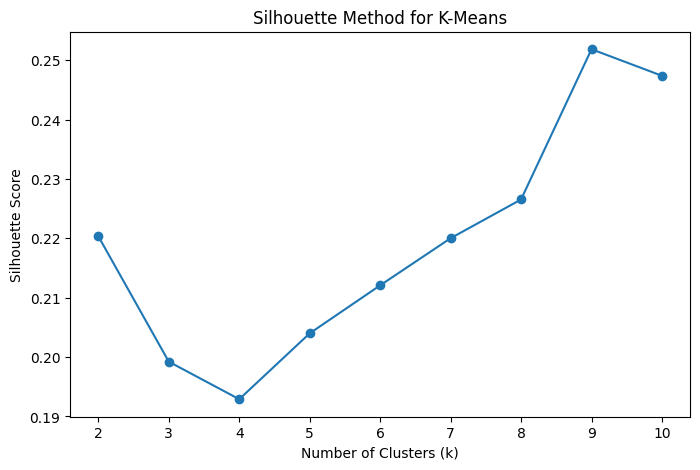

In [ ]:
# Cell 4: K-Means - Silhouette scores
silhouette_scores = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(8,5))
plt.plot(K, silhouette_scores, "o-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for K-Means")
plt.show()


K-Means ARI: 0.266
K-Means NMI: 0.204


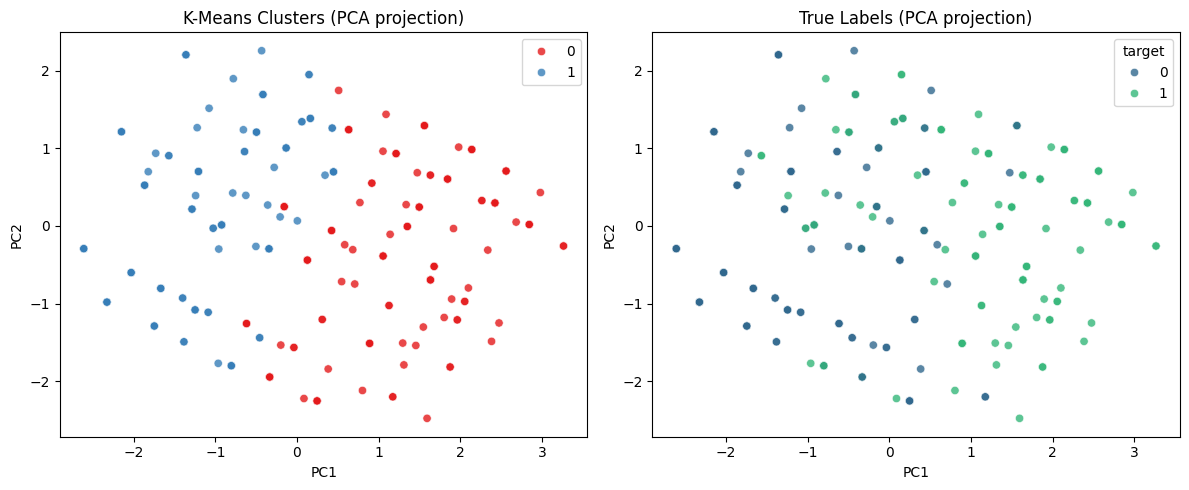

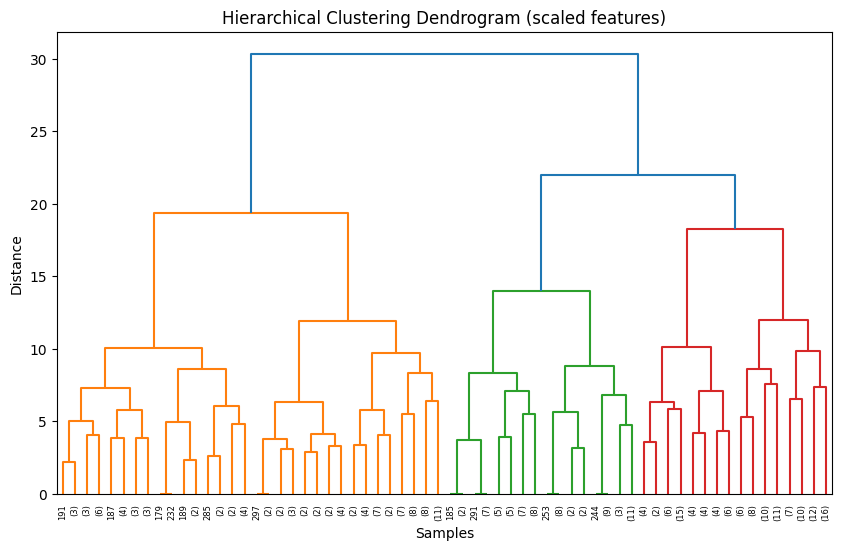

Hierarchical Clustering ARI: 0.287
Hierarchical Clustering NMI: 0.232


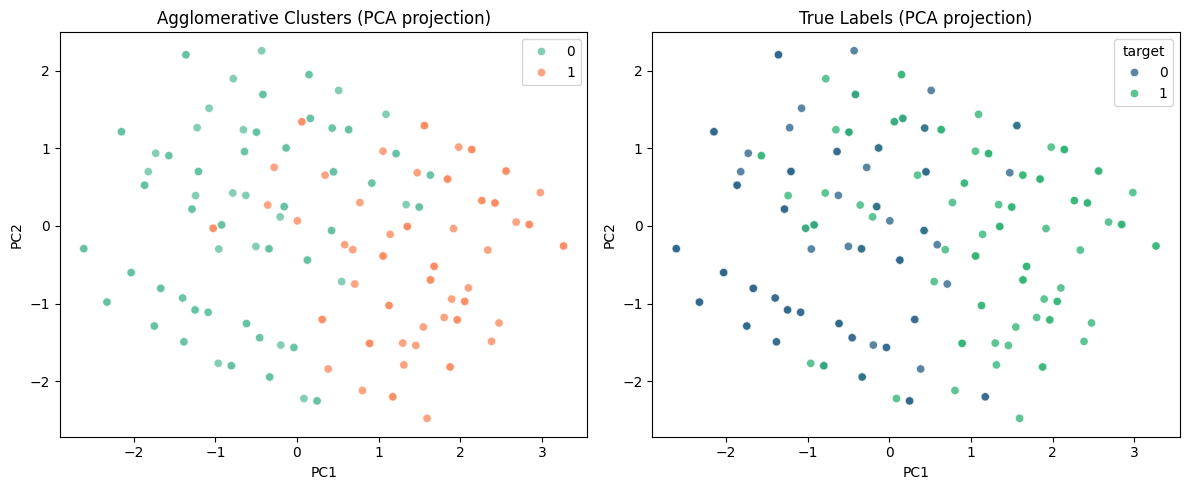

In [ ]:


# --- Ensure X_scaled is a DataFrame (so .iloc and .columns work later) ---
if not isinstance(X_scaled, pd.DataFrame):
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# --- Create a 2D PCA projection for visualization only (do NOT replace X_scaled) ---
pca_vis = PCA(n_components=2, random_state=42)
X_vis = pd.DataFrame(pca_vis.fit_transform(X_scaled), columns=["PC1", "PC2"], index=X_scaled.index)

# ---------------- K-Means on full scaled data (unchanged) ----------------
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X_scaled)   # clustering uses full scaled features

# Evaluate clustering with respect to true labels
ari = adjusted_rand_score(y, labels_km)
nmi = normalized_mutual_info_score(y, labels_km)

print("K-Means ARI:", round(ari,3))
print("K-Means NMI:", round(nmi,3))

# Visualization: use PCA projection (PC1 vs PC2) for plotting
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(x=X_vis["PC1"], y=X_vis["PC2"], hue=labels_km, palette="Set1", alpha=0.8, legend="full")
plt.title("K-Means Clusters (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1,2,2)
sns.scatterplot(x=X_vis["PC1"], y=X_vis["PC2"], hue=y, palette="viridis", alpha=0.8, legend="full")
plt.title("True Labels (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

# ---------------- Hierarchical Clustering (use full scaled data) ----------------
plt.figure(figsize=(10,6))
linkage_matrix = linkage(X_scaled.values, method="ward")  # use scaled values
dendrogram(linkage_matrix, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram (scaled features)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

hc = AgglomerativeClustering(n_clusters=2, linkage="ward")
labels_hc = hc.fit_predict(X_scaled)

ari_hc = adjusted_rand_score(y, labels_hc)
nmi_hc = normalized_mutual_info_score(y, labels_hc)

print("Hierarchical Clustering ARI:", round(ari_hc,3))
print("Hierarchical Clustering NMI:", round(nmi_hc,3))

# Plot Agglomerative clusters on the PCA projection
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(x=X_vis["PC1"], y=X_vis["PC2"], hue=labels_hc, palette="Set2", alpha=0.8, legend="full")
plt.title("Agglomerative Clusters (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1,2,2)
sns.scatterplot(x=X_vis["PC1"], y=X_vis["PC2"], hue=y, palette="viridis", alpha=0.8, legend="full")
plt.title("True Labels (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()


The PCA visualization shows significant overlap between classes. As expected, KMeans clustering fails to recover meaningful groups, achieving ARI ≈ 0.02. This highlights the need for supervised approaches for the heart disease dataset

Heart Disease dataset isn’t “cluster-friendly”

The UCI heart disease dataset has overlapping distributions between diseased and non-diseased patients.

Supervised methods (SVM, Random Forest) can draw nonlinear decision boundaries → that’s why 80–96% accuracy achieved.

Unsupervised methods like KMeans/HC can’t use labels, so they fail when classes are not naturally separable.

2. One-hot encoded categorical features hurt clustering

KMeans uses Euclidean distance, which doesn’t play nicely with sparse dummy variables.

partially fixed that with scaling, but it’s still not ideal.

3. PCA visualization vs clustering

PCA helps visualize, but it doesn’t guarantee separable clusters. The low ARI/NMI confirms that even in reduced space, the clusters overlap.


The base SVM achieved the highest ROC AUC (0.929), indicating slightly stronger class separation. However, the optimized SVM achieved higher accuracy (0.869) and F1-score (0.862), making it more effective at practical classification. Therefore, we selected the optimized SVM as the final model for deployment.